In [1]:
!pip install soundfile

import os
import glob
import torch
import IPython
import sklearn
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import librosa as ls
import soundfile as sf
from google.colab import drive
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader, RandomSampler, SequentialSampler

drive.mount('/content/drive')


torch.manual_seed(1)
if torch.cuda.is_available():     
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [2]:
window = 1024 
batch_size = 64
epochs = 150
learning_rate = 0.001
steps = epochs-25

I've  decided to go with simple autoencoder architecture, so one of the main problem for me is that all audio have different sizes, hence I have to truncade and pad with zeroes some audios.


To have access to the GPU I have to use Google colab, so I have uploaded the audio dataset in the google drive and I can tun my script right in the colab notebook.

In [3]:
os.chdir('/content/drive/My Drive/testMIL')
from model.model import Model,train
!python add_noise.py '/content/drive/My Drive/testMIL/Data' 0.1


#### Prepare Train,Valid,Test datasets

In [4]:
def transform_audio(size,data):
  length = size[0] * size[1]
  data_len = data.shape[0]
  if data_len < length:
    return np.concatenate((data,np.zeros(length - data_len))).reshape(size)
  elif data_len == length:
    return data.reshape(size)
  else: 
    return data[:length].reshape(size)

def data_to_dataloader(train_dataset,val_dataset,batch_size):
  """
  Create the DataLoaders for sets.
  I'll take training samples in random order. 
  For val and test in sequentional way.

  """
  
  train_dataloader = DataLoader(
              train_dataset, 
              sampler = RandomSampler(train_dataset),
              batch_size = batch_size 
              )

  validation_dataloader = DataLoader(
              val_dataset, 
              sampler = SequentialSampler(val_dataset), 
              batch_size = batch_size
              )

  return train_dataloader,validation_dataloader

In [5]:
main_path = '/content/drive/My Drive/testMIL'
n_path = '/content/drive/My Drive/testMIL/NoisyData'

with open(os.path.join(main_path,'audio_paths.txt'),'r') as f:
  audio_paths = f.read().splitlines()


ds_clean = np.empty((1,window))
ds_noisy = np.empty((1,window))
for path in audio_paths:
  data_cl,_ = ls.load(path)
  file_name = os.path.split(path)[-1].strip('.flac') + '.wav'
  data_ns,_ = sf.read(os.path.join(n_path,file_name))
  ideal_size = (int(len(data_cl)/window),window)
  ds_clean = np.concatenate((ds_clean,transform_audio(ideal_size,data_cl)),
                            axis = 0)
  ds_noisy = np.concatenate((ds_noisy,transform_audio(ideal_size,data_ns)),
                            axis = 0)

ds_clean,ds_noisy = ds_clean[1:],ds_noisy[1:]

# np.save("ds_clean.npy", ds_clean)
# np.save("ds_noisy.npy",ds_noisy)

# ds_clean = np.load("ds_clean03.npy")
# ds_noisy = np.load("ds_noisy03.npy")

# Train test split.
X_train, X_val, y_train, y_val = train_test_split(ds_noisy, ds_clean,
                                                    test_size=0.2,
                                                    random_state=42)

del ds_clean,ds_noisy

In [6]:
print("X_train shape = ",X_train.shape)
print("X_val shape = ",X_val.shape)

X_train shape =  (211291, 1024)
X_val shape =  (52823, 1024)


In [9]:
# Prepare datasets
train_dataset = TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
val_dataset = TensorDataset(torch.tensor(X_val.astype(np.float32)), torch.tensor(y_val.astype(np.float32)))

train_dataloader,validation_dataloader = data_to_dataloader(train_dataset,val_dataset,batch_size) 

In [ ]:
model = Model()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

vall_loss,train_loss,model = train(model, device, optimizer, scheduler,
                                   train_dataloader, validation_dataloader, 
                                   epochs = epochs ,seed_val = 42)

try:
  os.mkdir("weights")
except:
  pass

torch.save(model.state_dict(), "weights/weights150")

In [ ]:

epochs = 300
learning_rate = 0.001


model3 = Model()
model3.load_state_dict(torch.load("weights/weights150"))

model3.to(device)

optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

vall_los4,train_los4,model4 = train(model3, device, optimizer, scheduler,
                                   train_dataloader, validation_dataloader, 
                                   epochs = epochs ,seed_val = 42)

try:
  os.mkdir("weights")
except:
  pass

torch.save(model4.state_dict(), "weights/weights450")


In [43]:

sns.set_style("whitegrid")
paths = glob.glob('/content/drive/My Drive/testMIL/NOISY_AUDIO_TEST/*.wav')
for path in paths:
  name = os.path.split(path)[-1]
  print("AUDIO_FILE: ",name)
  ds_noisy = np.empty((1,window))
  data_ns,_ = ls.load(path)
  ideal_size = (int(len(data_cl)/window),window)
  ds_noisy = np.concatenate((ds_noisy,transform_audio(ideal_size,data_ns)),
                          axis = 0)

  ds_noisy = ds_noisy[1:]
  x = torch.tensor(ds_noisy.astype(np.float32))
  y_pred = model4(x.unsqueeze(1).to(device))
  
  audio = y_pred.squeeze(1).flatten().to("cpu").detach().numpy()
  print("NOISY")
  IPython.display.display(IPython.display.Audio(data=x.numpy().flatten(), rate=22050))
  print('CLEAN')
  IPython.display.display(IPython.display.Audio(data=audio, rate=22050))
  sf.write(os.path.join("/content/drive/My Drive/testMIL/CLEAN_AUDIO_TEST_NN",name), audio, 22050)
  print('MSE: ',sklearn.metrics.mean_squared_error(x.numpy().flatten(),audio))
  print('')


AUDIO_FILE:  5.wav
NOISY


CLEAN


MSE:  0.000100809586

AUDIO_FILE:  2.wav
NOISY


CLEAN


MSE:  0.00012579234

AUDIO_FILE:  4.wav
NOISY


CLEAN


MSE:  0.00026507958

AUDIO_FILE:  3.wav
NOISY


CLEAN


MSE:  0.00016264599

AUDIO_FILE:  1.wav
NOISY


CLEAN


MSE:  0.00016499074



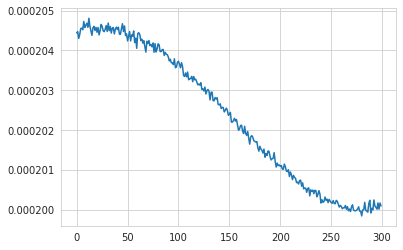

In [39]:
plt.plot(train_los4)

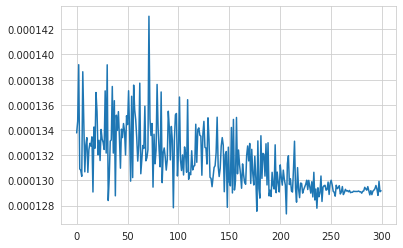

In [42]:
plt.plot(vall_los4)